In [ ]:
import wandb

api = wandb.Api()
qwen14B_run = api.run("nobleai-xjtu/verl_rej_test/runs/verl_rej_test--qwen25_14B_mi300_2node_16k_2k_math_filtered_dis_mathqa_256bsz_20ksamples_grpo_subem_end")
qwen14B_filter_run = api.run("nobleai-xjtu/verl_rej_test/verl_rej_test--qwen14b_2e_1node_16k_2k_FILTERedAGAIN_dis_256bsz_grpo_SUBEM_end")
print(f"length of qwen14B_run.history(): {len(qwen14B_run.history())}")
print(f"length of qwen14B_filter_run.history(): {len(qwen14B_filter_run.history())}")
# distractor 2 epoch 168 steps
# filter 5 epoch 150 steps

length of qwen14B_run.history(): 218
length of qwen14B_filter_run.history(): 164


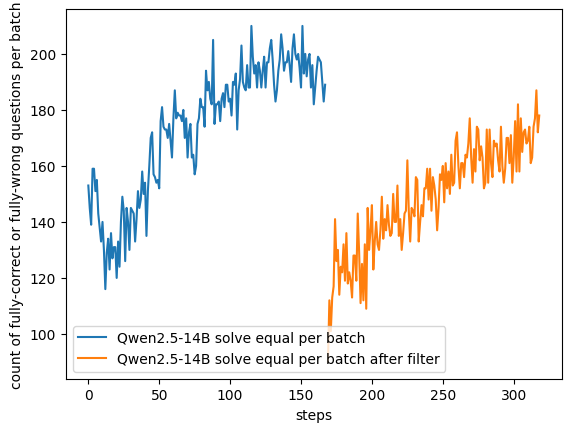

In [21]:
# plot solve equal
import matplotlib.pyplot as plt

y = (qwen14B_run.history()['batch/solve_equal'].tolist()[1:169])
plt.plot(range(len(y)), y, label='Qwen2.5-14B solve equal per batch')
y_2 = (qwen14B_filter_run.history()['batch/solve_equal'].tolist()[1:151])
plt.plot(range(169, len(y_2)+169), y_2, label='Qwen2.5-14B solve equal per batch after filter')
plt.xlabel('steps')
plt.ylabel('count of fully-correct or fully-wrong questions per batch')
plt.legend()

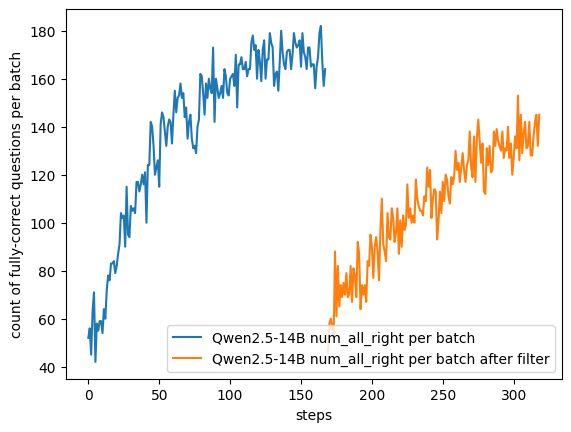

In [22]:
import matplotlib.pyplot as plt

y = (qwen14B_run.history()['critic/num_all_right'].tolist()[1:169])
plt.plot(range(len(y)), y, label='Qwen2.5-14B num_all_right per batch')
y_2 = (qwen14B_filter_run.history()['critic/num_all_right'].tolist()[1:151])
plt.plot(range(169, len(y_2)+169), y_2, label='Qwen2.5-14B num_all_right per batch after filter')
plt.xlabel('steps')
plt.ylabel('count of fully-correct questions per batch')
plt.legend()

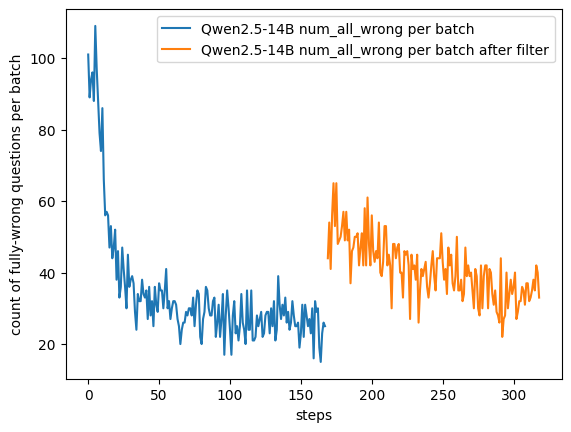

In [23]:
import matplotlib.pyplot as plt

y = (qwen14B_run.history()['critic/num_all_wrong'].tolist()[1:169])
plt.plot(range(len(y)), y, label='Qwen2.5-14B num_all_wrong per batch')
y_2 = (qwen14B_filter_run.history()['critic/num_all_wrong'].tolist()[1:151])
plt.plot(range(169, len(y_2)+169), y_2, label='Qwen2.5-14B num_all_wrong per batch after filter')
plt.xlabel('steps')
plt.ylabel('count of fully-wrong questions per batch')
plt.legend()

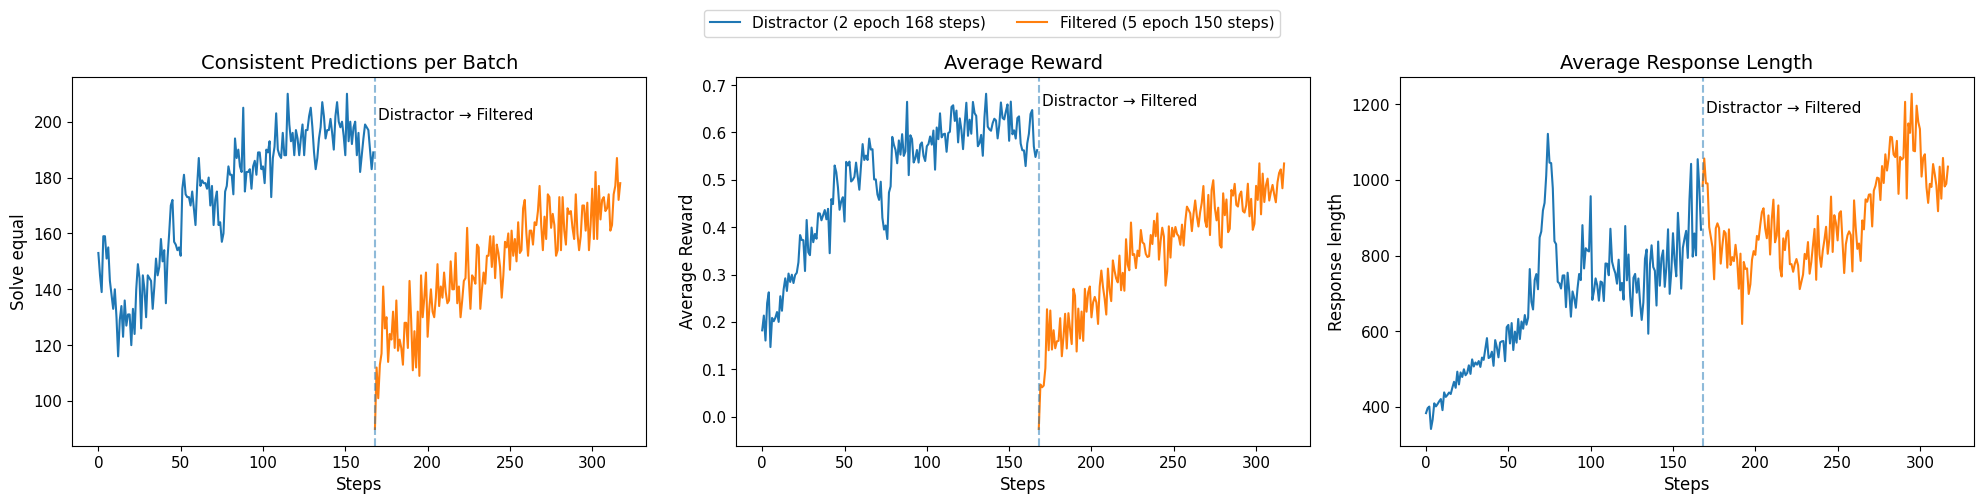

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wandb

api = wandb.Api()

# 两个 run
qwen14B_run = api.run(
    "nobleai-xjtu/verl_rej_test/runs/verl_rej_test--qwen25_14B_mi300_2node_16k_2k_math_filtered_dis_mathqa_256bsz_20ksamples_grpo_subem_end"
)
qwen14B_filter_run = api.run(
    "nobleai-xjtu/verl_rej_test/verl_rej_test--qwen14b_2e_1node_16k_2k_FILTERedAGAIN_dis_256bsz_grpo_SUBEM_end"
)

BATCHSIZE = 256

# ---------- helpers ----------
def fixed_reward_series(run, batchsize=BATCHSIZE):
    hist = run.history(keys=[
        "critic/returns/mean",
        "critic/num_all_right",
        "critic/num_all_wrong",
    ])
    returns_mean = np.array(hist.get("critic/returns/mean", []), dtype=float)
    num_right    = np.array(hist.get("critic/num_all_right", []), dtype=float)
    num_wrong    = np.array(hist.get("critic/num_all_wrong", []), dtype=float)
    L = min(len(returns_mean), len(num_right), len(num_wrong))
    returns_mean, num_right, num_wrong = returns_mean[:L], num_right[:L], num_wrong[:L]
    return (returns_mean * (batchsize - num_wrong - num_right) + num_right) / batchsize

def get_response_length(run):
    hist = run.history(keys=["response_length/mean"])
    return np.array(hist.get("response_length/mean", []), dtype=float)

def get_solve_equal(run):
    hist = run.history(keys=["batch/solve_equal"])
    return np.array(hist.get("batch/solve_equal", []), dtype=float)

# ---------- data ----------
y_dis_rew   = fixed_reward_series(qwen14B_run)
y_filt_rew  = fixed_reward_series(qwen14B_filter_run)

y_dis_len   = get_response_length(qwen14B_run)
y_filt_len  = get_response_length(qwen14B_filter_run)

y_dis_solve = get_solve_equal(qwen14B_run)
y_filt_solve= get_solve_equal(qwen14B_filter_run)

# ---------- step counts ----------
x1, x2 = 168, 150
split_points = [(x1, "Distractor → Filtered")]

# ---------- plots ----------
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=False)
plt.subplots_adjust(wspace=0.3)

# ---- 图1: solve equal ----
ax = axes[0]
ax.plot(range(0, x1), y_dis_solve[:x1], label="Distractor (2 epoch 168 steps)")
ax.plot(range(x1, x1+x2), y_filt_solve[:x2], label="Filtered (5 epoch 150 steps)")
for xpos, name in split_points:
    ax.axvline(x=xpos, linestyle="--", alpha=0.5)
    ax.text(xpos+2, ax.get_ylim()[1]*0.95, name, fontsize=11, va="top")
ax.set_xlabel("Steps")
ax.set_ylabel("Solve equal")
ax.set_title("Consistent Predictions per Batch")

# ---- 图2: fixed reward ----
ax = axes[1]
ax.plot(range(0, x1), y_dis_rew[:x1], label="Distractor (2 epoch 168 steps)")
ax.plot(range(x1, x1+x2), y_filt_rew[:x2], label="Filtered (5 epoch 150 steps)")
for xpos, name in split_points:
    ax.axvline(x=xpos, linestyle="--", alpha=0.5)
    ax.text(xpos+2, ax.get_ylim()[1]*0.95, name, fontsize=11, va="top")
ax.set_xlabel("Steps")
ax.set_ylabel("Average Reward")
ax.set_title("Average Reward")

# ---- 图3: response length ----
ax = axes[2]
ax.plot(range(0, x1), y_dis_len[:x1], label="Distractor (2 epoch 168 steps)")
ax.plot(range(x1, x1+x2), y_filt_len[:x2], label="Filtered (5 epoch 150 steps)")
for xpos, name in split_points:
    ax.axvline(x=xpos, linestyle="--", alpha=0.5)
    ax.text(xpos+2, ax.get_ylim()[1]*0.95, name, fontsize=11, va="top")
ax.set_xlabel("Steps")
ax.set_ylabel("Response length")
ax.set_title("Average Response Length")

# ---------- global legend ----------
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.subplots_adjust(top=0.87)  # 给上方 legend 留空间
plt.show()

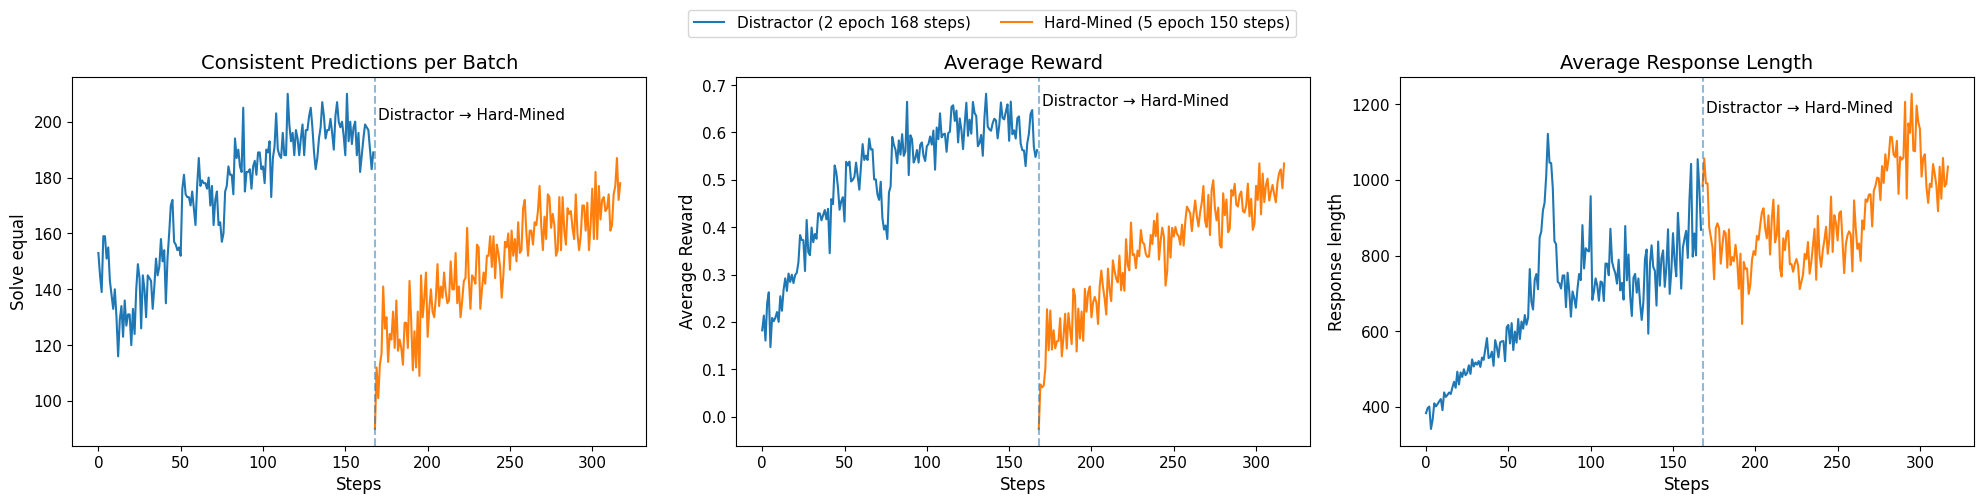

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wandb

api = wandb.Api()

# 两个 run
qwen14B_run = api.run(
    "nobleai-xjtu/verl_rej_test/runs/verl_rej_test--qwen25_14B_mi300_2node_16k_2k_math_filtered_dis_mathqa_256bsz_20ksamples_grpo_subem_end"
)
qwen14B_filter_run = api.run(
    "nobleai-xjtu/verl_rej_test/verl_rej_test--qwen14b_2e_1node_16k_2k_FILTERedAGAIN_dis_256bsz_grpo_SUBEM_end"
)

BATCHSIZE = 256

# ---------- helpers ----------
def fixed_reward_series(run, batchsize=BATCHSIZE):
    hist = run.history(keys=[
        "critic/returns/mean",
        "critic/num_all_right",
        "critic/num_all_wrong",
    ])
    returns_mean = np.array(hist.get("critic/returns/mean", []), dtype=float)
    num_right    = np.array(hist.get("critic/num_all_right", []), dtype=float)
    num_wrong    = np.array(hist.get("critic/num_all_wrong", []), dtype=float)
    L = min(len(returns_mean), len(num_right), len(num_wrong))
    returns_mean, num_right, num_wrong = returns_mean[:L], num_right[:L], num_wrong[:L]
    return (returns_mean * (batchsize - num_wrong - num_right) + num_right) / batchsize

def get_response_length(run):
    hist = run.history(keys=["response_length/mean"])
    return np.array(hist.get("response_length/mean", []), dtype=float)

def get_solve_equal(run):
    hist = run.history(keys=["batch/solve_equal"])
    return np.array(hist.get("batch/solve_equal", []), dtype=float)

# ---------- data ----------
y_dis_rew   = fixed_reward_series(qwen14B_run)
y_filt_rew  = fixed_reward_series(qwen14B_filter_run)

y_dis_len   = get_response_length(qwen14B_run)
y_filt_len  = get_response_length(qwen14B_filter_run)

y_dis_solve = get_solve_equal(qwen14B_run)
y_filt_solve= get_solve_equal(qwen14B_filter_run)

# ---------- step counts ----------
x1, x2 = 168, 150
split_points = [(x1, "Distractor → Hard-Mined")]

# ---------- plots ----------
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=False)
plt.subplots_adjust(wspace=0.3)

# ---- 图1: solve equal ----
ax = axes[0]
ax.plot(range(0, x1), y_dis_solve[:x1], label="Distractor (2 epoch 168 steps)")
ax.plot(range(x1, x1+x2), y_filt_solve[:x2], label="Hard-Mined (5 epoch 150 steps)")
for xpos, name in split_points:
    ax.axvline(x=xpos, linestyle="--", alpha=0.5)
    ax.text(xpos+2, ax.get_ylim()[1]*0.95, name, fontsize=11, va="top")
ax.set_xlabel("Steps")
ax.set_ylabel("Solve equal")
ax.set_title("Consistent Predictions per Batch")

# ---- 图2: fixed reward ----
ax = axes[1]
ax.plot(range(0, x1), y_dis_rew[:x1], label="Distractor (2 epoch 168 steps)")
ax.plot(range(x1, x1+x2), y_filt_rew[:x2], label="Hard-Mined (5 epoch 150 steps)")
for xpos, name in split_points:
    ax.axvline(x=xpos, linestyle="--", alpha=0.5)
    ax.text(xpos+2, ax.get_ylim()[1]*0.95, name, fontsize=11, va="top")
ax.set_xlabel("Steps")
ax.set_ylabel("Average Reward")
ax.set_title("Average Reward")

# ---- 图3: response length ----
ax = axes[2]
ax.plot(range(0, x1), y_dis_len[:x1], label="Distractor (2 epoch 168 steps)")
ax.plot(range(x1, x1+x2), y_filt_len[:x2], label="Hard-Mined (5 epoch 150 steps)")
for xpos, name in split_points:
    ax.axvline(x=xpos, linestyle="--", alpha=0.5)
    ax.text(xpos+2, ax.get_ylim()[1]*0.95, name, fontsize=11, va="top")
ax.set_xlabel("Steps")
ax.set_ylabel("Response length")
ax.set_title("Average Response Length")

# ---------- global legend ----------
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.subplots_adjust(top=0.87)  # 给上方 legend 留空间
plt.show()

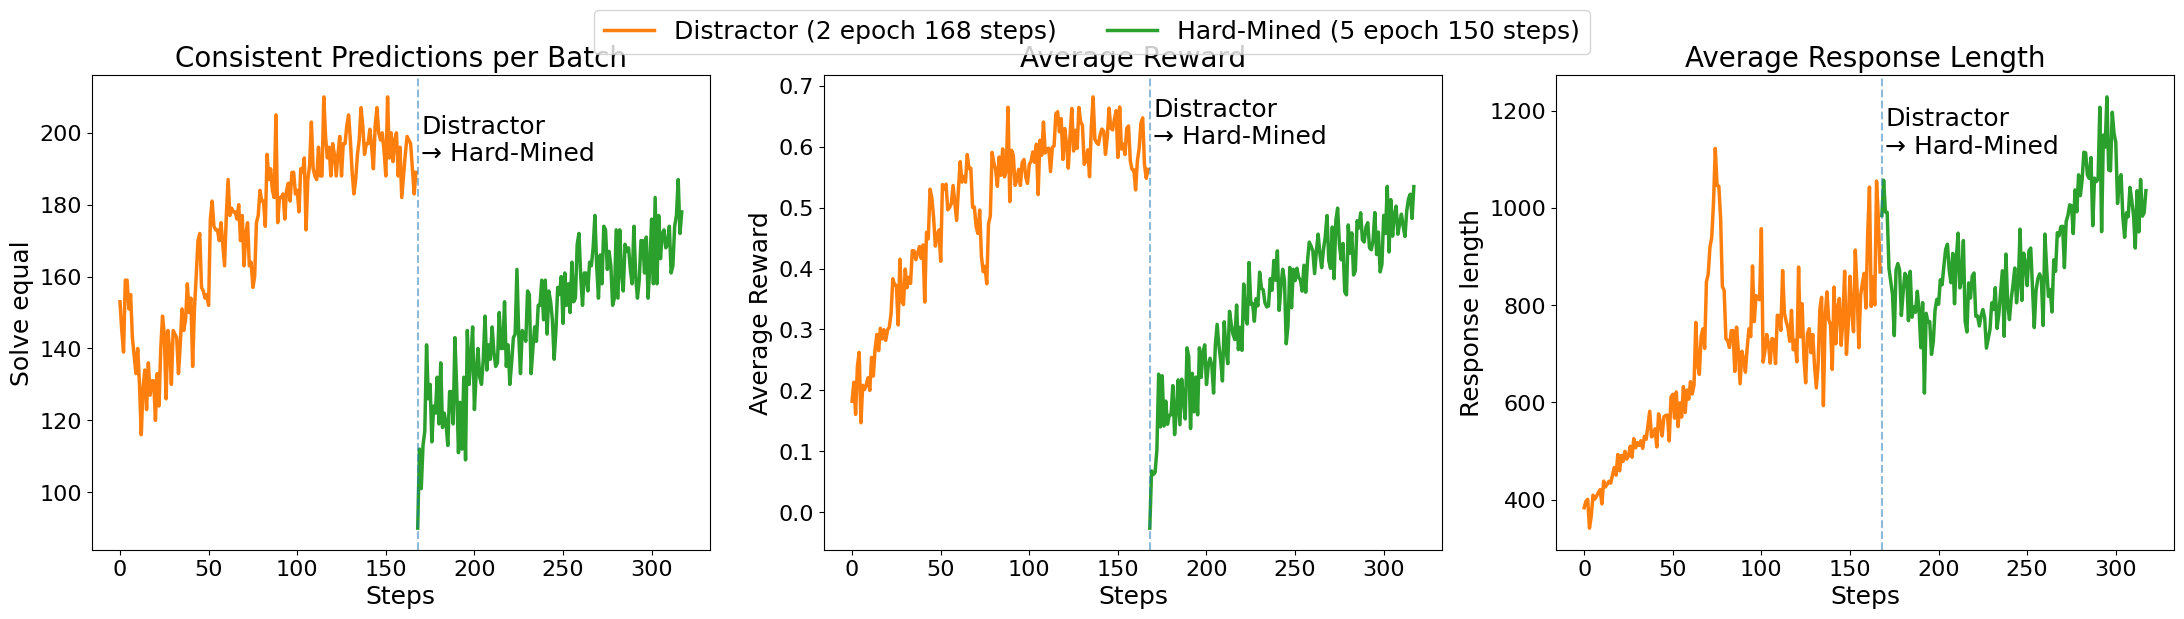

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import wandb

api = wandb.Api()

# 两个 run
qwen14B_run = api.run(
    "nobleai-xjtu/verl_rej_test/runs/verl_rej_test--qwen25_14B_mi300_2node_16k_2k_math_filtered_dis_mathqa_256bsz_20ksamples_grpo_subem_end"
)
qwen14B_filter_run = api.run(
    "nobleai-xjtu/verl_rej_test/verl_rej_test--qwen14b_2e_1node_16k_2k_FILTERedAGAIN_dis_256bsz_grpo_SUBEM_end"
)

BATCHSIZE = 256

# ---------- helpers ----------
def fixed_reward_series(run, batchsize=BATCHSIZE):
    hist = run.history(keys=[
        "critic/returns/mean",
        "critic/num_all_right",
        "critic/num_all_wrong",
    ])
    returns_mean = np.array(hist.get("critic/returns/mean", []), dtype=float)
    num_right    = np.array(hist.get("critic/num_all_right", []), dtype=float)
    num_wrong    = np.array(hist.get("critic/num_all_wrong", []), dtype=float)
    L = min(len(returns_mean), len(num_right), len(num_wrong))
    returns_mean, num_right, num_wrong = returns_mean[:L], num_right[:L], num_wrong[:L]
    return (returns_mean * (batchsize - num_wrong - num_right) + num_right) / batchsize

def get_response_length(run):
    hist = run.history(keys=["response_length/mean"])
    return np.array(hist.get("response_length/mean", []), dtype=float)

def get_solve_equal(run):
    hist = run.history(keys=["batch/solve_equal"])
    return np.array(hist.get("batch/solve_equal", []), dtype=float)

# ---------- data ----------
y_dis_rew   = fixed_reward_series(qwen14B_run)
y_filt_rew  = fixed_reward_series(qwen14B_filter_run)

y_dis_len   = get_response_length(qwen14B_run)
y_filt_len  = get_response_length(qwen14B_filter_run)

y_dis_solve = get_solve_equal(qwen14B_run)
y_filt_solve= get_solve_equal(qwen14B_filter_run)

# ---------- step counts ----------
x1, x2 = 168, 150
split_points = [(x1, "Distractor\n→ Hard-Mined")]

# ---------- style ----------
line_width = 2.5
label_fontsize = 18
title_fontsize = 20
tick_fontsize = 16
legend_fontsize = 18
split_fontsize = 18

fig, axes = plt.subplots(1, 3, figsize=(22, 6), sharex=False)
plt.subplots_adjust(wspace=0.3)

# ---- 图1: solve equal ----
ax = axes[0]
ax.plot(range(0, x1), y_dis_solve[:x1], label="Distractor (2 epoch 168 steps)", color="C1", linewidth=line_width)
ax.plot(range(x1, x1+x2), y_filt_solve[:x2], label="Hard-Mined (5 epoch 150 steps)", color="C2", linewidth=line_width)
for xpos, name in split_points:
    ax.axvline(x=xpos, linestyle="--", alpha=0.5, linewidth=1.5)
    ax.text(xpos+2, ax.get_ylim()[1]*0.95, name, fontsize=split_fontsize, va="top")
ax.set_xlabel("Steps", fontsize=label_fontsize)
ax.set_ylabel("Solve equal", fontsize=label_fontsize)
ax.set_title("Consistent Predictions per Batch", fontsize=title_fontsize)
ax.tick_params(axis="both", labelsize=tick_fontsize)

# ---- 图2: fixed reward ----
ax = axes[1]
ax.plot(range(0, x1), y_dis_rew[:x1], label="Distractor (2 epoch 168 steps)", color="C1", linewidth=line_width)
ax.plot(range(x1, x1+x2), y_filt_rew[:x2], label="Hard-Mined (5 epoch 150 steps)", color="C2", linewidth=line_width)
for xpos, name in split_points:
    ax.axvline(x=xpos, linestyle="--", alpha=0.5, linewidth=1.5)
    ax.text(xpos+2, ax.get_ylim()[1]*0.95, name, fontsize=split_fontsize, va="top")
ax.set_xlabel("Steps", fontsize=label_fontsize)
ax.set_ylabel("Average Reward", fontsize=label_fontsize)
ax.set_title("Average Reward", fontsize=title_fontsize)
ax.tick_params(axis="both", labelsize=tick_fontsize)

# ---- 图3: response length ----
ax = axes[2]
ax.plot(range(0, x1), y_dis_len[:x1], label="Distractor (2 epoch 168 steps)", color="C1", linewidth=line_width)
ax.plot(range(x1, x1+x2), y_filt_len[:x2], label="Hard-Mined (5 epoch 150 steps)", color="C2", linewidth=line_width)
for xpos, name in split_points:
    ax.axvline(x=xpos, linestyle="--", alpha=0.5, linewidth=1.5)
    ax.text(xpos+2, ax.get_ylim()[1]*0.95, name, fontsize=split_fontsize, va="top")
ax.set_xlabel("Steps", fontsize=label_fontsize)
ax.set_ylabel("Response length", fontsize=label_fontsize)
ax.set_title("Average Response Length", fontsize=title_fontsize)
ax.tick_params(axis="both", labelsize=tick_fontsize)

# ---------- global legend ----------
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.05), fontsize=legend_fontsize)

plt.tight_layout()
# plt.subplots_adjust(top=0.85)  # 给上方 legend 留空间
plt.savefig("qwen-14b_keychain_train_hardmined_font_big.pdf")
plt.show()

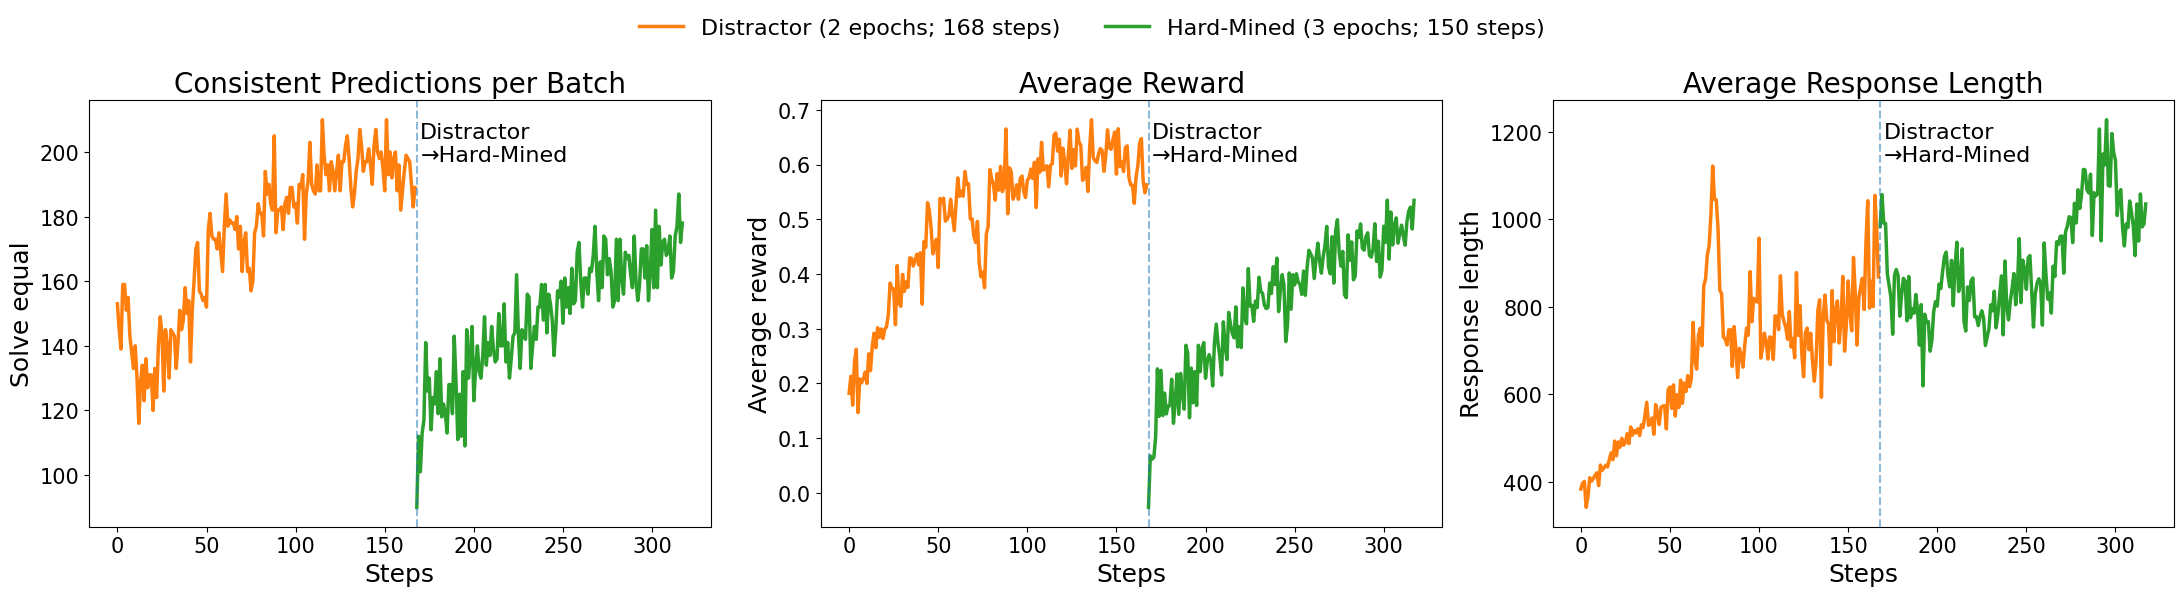

In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Training metrics plot for rStar2-Long-14B (two-stage schedule).
- Left: Consistent Predictions per Batch (Solve equal)
- Middle: Average Reward (fixed-reward proxy)
- Right: Average Response Length
The global legend sits above the panels and is saved without being clipped.
"""

import numpy as np
import matplotlib.pyplot as plt
import wandb

# -----------------------------
# Config
# -----------------------------
PROJECT_RUN_1 = "nobleai-xjtu/verl_rej_test/runs/verl_rej_test--qwen25_14B_mi300_2node_16k_2k_math_filtered_dis_mathqa_256bsz_20ksamples_grpo_subem_end"  # Distractor phase
PROJECT_RUN_2 = "nobleai-xjtu/verl_rej_test/verl_rej_test--qwen14b_2e_1node_16k_2k_FILTERedAGAIN_dis_256bsz_grpo_SUBEM_end"                               # Hard-mined phase

# Stage lengths (steps)
X1 = 168  # Distractor
X2 = 150  # Hard-mined

BATCHSIZE = 256

# -----------------------------
# Data helpers
# -----------------------------
def fixed_reward_series(run, batchsize=BATCHSIZE):
    """Return per-step fixed-reward estimate: (mean_return * (B - wrong - right) + right) / B"""
    hist = run.history(keys=[
        "critic/returns/mean",
        "critic/num_all_right",
        "critic/num_all_wrong",
    ])
    returns_mean = np.array(hist.get("critic/returns/mean", []), dtype=float)
    num_right    = np.array(hist.get("critic/num_all_right", []), dtype=float)
    num_wrong    = np.array(hist.get("critic/num_all_wrong", []), dtype=float)
    L = min(len(returns_mean), len(num_right), len(num_wrong))
    returns_mean, num_right, num_wrong = returns_mean[:L], num_right[:L], num_wrong[:L]
    return (returns_mean * (batchsize - num_wrong - num_right) + num_right) / batchsize

def get_response_length(run):
    hist = run.history(keys=["response_length/mean"])
    return np.array(hist.get("response_length/mean", []), dtype=float)

def get_solve_equal(run):
    hist = run.history(keys=["batch/solve_equal"])
    return np.array(hist.get("batch/solve_equal", []), dtype=float)

# -----------------------------
# Fetch data from W&B
# -----------------------------
api = wandb.Api()
run_dis   = api.run(PROJECT_RUN_1)  # Distractor
run_hm    = api.run(PROJECT_RUN_2)  # Hard-mined

y_dis_rew    = fixed_reward_series(run_dis)
y_hm_rew     = fixed_reward_series(run_hm)

y_dis_len    = get_response_length(run_dis)
y_hm_len     = get_response_length(run_hm)

y_dis_solve  = get_solve_equal(run_dis)
y_hm_solve   = get_solve_equal(run_hm)

# Truncate to declared stage lengths to align x-axes cleanly
y_dis_rew   = y_dis_rew[:X1]
y_hm_rew    = y_hm_rew[:X2]
y_dis_len   = y_dis_len[:X1]
y_hm_len    = y_hm_len[:X2]
y_dis_solve = y_dis_solve[:X1]
y_hm_solve  = y_hm_solve[:X2]

# -----------------------------
# Plot
# -----------------------------
line_width = 2.5
label_fontsize = 18
title_fontsize = 20
tick_fontsize = 15
legend_fontsize = 16
split_fontsize = 16

# Using constrained_layout makes panels behave well;
# we still reserve top space for legend explicitly.
fig, axes = plt.subplots(1, 3, figsize=(22, 6), constrained_layout=False)
plt.subplots_adjust(wspace=0.30)

colors = {"dis": "C1", "hm": "C2"}
legend_dis = "Distractor (2 epochs; 168 steps)"
legend_hm  = "Hard-Mined (3 epochs; 150 steps)"

# X for two stages on a shared axis
x_dis = np.arange(0, X1)
x_hm  = np.arange(X1, X1 + X2)

def add_stage_split(ax, xpos, label):
    ax.axvline(x=xpos, linestyle="--", alpha=0.5, linewidth=1.5)
    # Place text just inside upper region
    ymin, ymax = ax.get_ylim()
    ax.text(xpos + 2, ymax - 0.05*(ymax - ymin), label, fontsize=split_fontsize, va="top")

# Panel 1: Solve equal
ax = axes[0]
ax.plot(x_dis, y_dis_solve, label=legend_dis, color=colors["dis"], linewidth=line_width)
ax.plot(x_hm,  y_hm_solve,  label=legend_hm,  color=colors["hm"],  linewidth=line_width)
add_stage_split(ax, X1, "Distractor\n→Hard-Mined")
ax.set_xlabel("Steps", fontsize=label_fontsize)
ax.set_ylabel("Solve equal", fontsize=label_fontsize)
ax.set_title("Consistent Predictions per Batch", fontsize=title_fontsize)
ax.tick_params(axis="both", labelsize=tick_fontsize)

# Panel 2: Average Reward
ax = axes[1]
ax.plot(x_dis, y_dis_rew, label=legend_dis, color=colors["dis"], linewidth=line_width)
ax.plot(x_hm,  y_hm_rew,  label=legend_hm,  color=colors["hm"],  linewidth=line_width)
add_stage_split(ax, X1, "Distractor\n→Hard-Mined")
ax.set_xlabel("Steps", fontsize=label_fontsize)
ax.set_ylabel("Average reward", fontsize=label_fontsize)
ax.set_title("Average Reward", fontsize=title_fontsize)
ax.tick_params(axis="both", labelsize=tick_fontsize)

# Panel 3: Response Length
ax = axes[2]
ax.plot(x_dis, y_dis_len, label=legend_dis, color=colors["dis"], linewidth=line_width)
ax.plot(x_hm,  y_hm_len,  label=legend_hm,  color=colors["hm"],  linewidth=line_width)
add_stage_split(ax, X1, "Distractor\n→Hard-Mined")
ax.set_xlabel("Steps", fontsize=label_fontsize)
ax.set_ylabel("Response length", fontsize=label_fontsize)
ax.set_title("Average Response Length", fontsize=title_fontsize)
ax.tick_params(axis="both", labelsize=tick_fontsize)

# -----------------------------
# Global legend (not clipped)
# -----------------------------
# -----------------------------
# Global legend (closer to plots)
# -----------------------------
handles, labels = axes[-1].get_legend_handles_labels()
lgd = fig.legend(
    handles, labels,
    loc="upper center",
    ncol=2,
    bbox_to_anchor=(0.5, 1.01),  # legend 更靠近图
    fontsize=legend_fontsize,
    frameon=False
)

# Reserve less space on top (top=0.92 instead of 0.88)
fig.tight_layout(rect=[0.0, 0.0, 1.0, 0.92])

# Save without clipping legend
outfile = "qwen-14b_keychain_train_hardmined_font_big.pdf"
fig.savefig(
    outfile,
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
    pad_inches=0.02
)

/tmp/ipykernel_1593999/3935833494.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.92])
/tmp/ipykernel_1593999/3935833494.py:149: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.92])


Saved to qwen-14b_keychain_train_hardmined_font_big.pdf


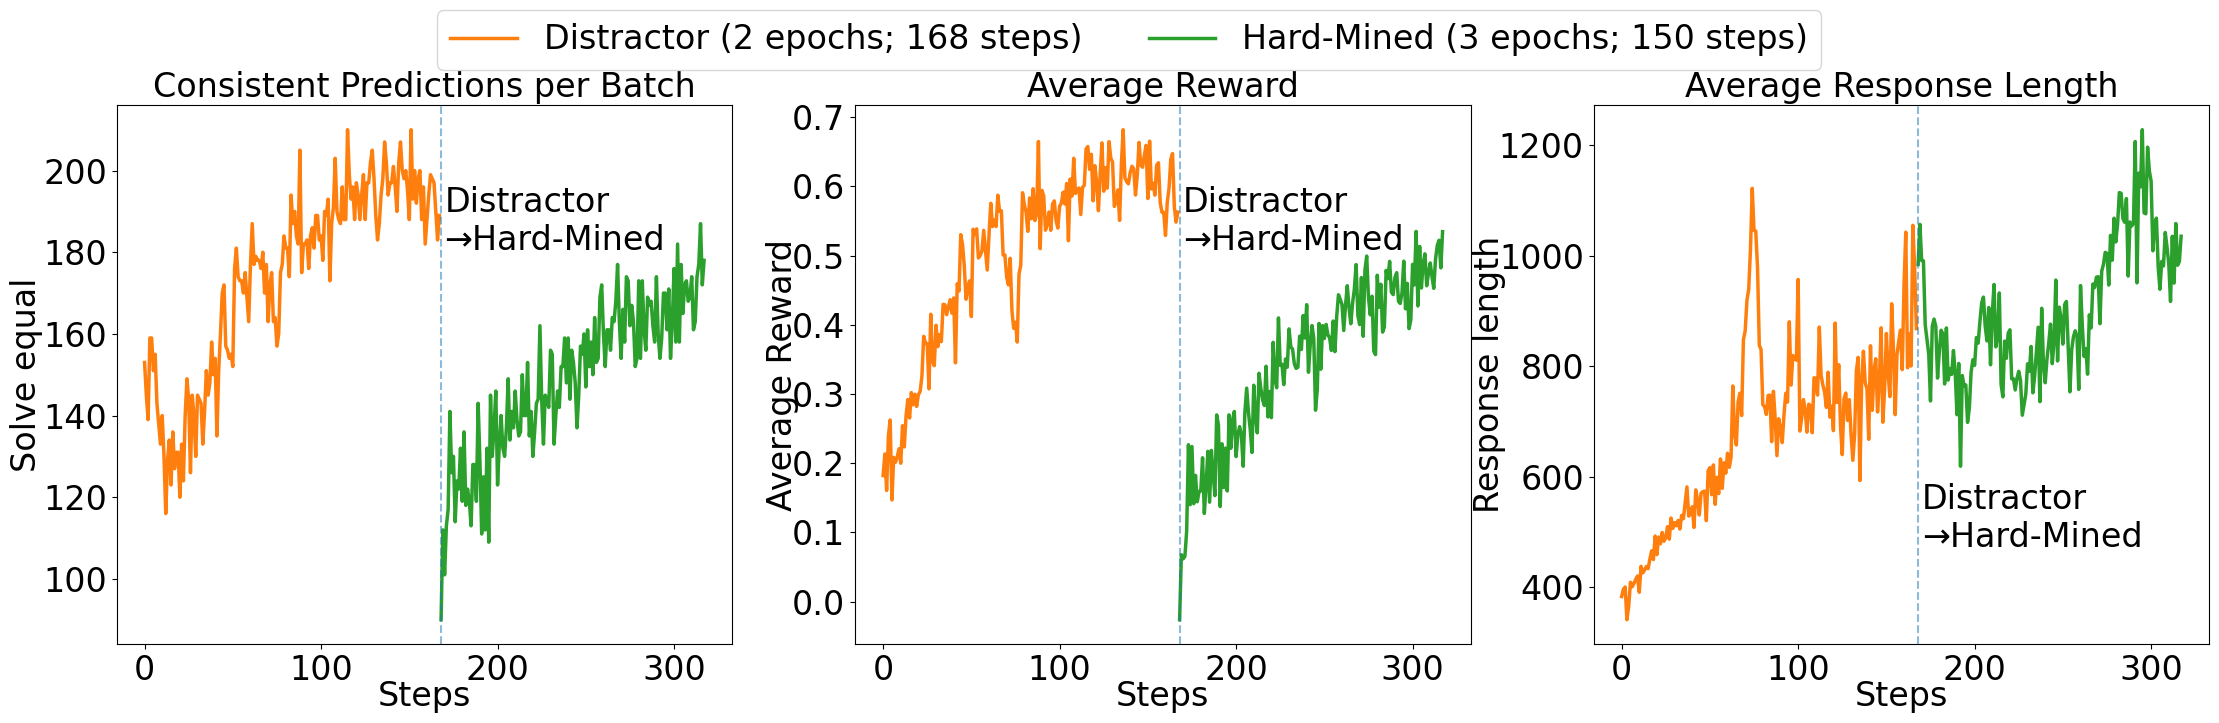

In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Training metrics plot for rStar2-Long-14B (two-stage schedule).
- Left: Consistent Predictions per Batch (Solve equal)
- Middle: Average Reward (fixed-reward proxy)
- Right: Average Response Length
Layout: constrained_layout (tight & even), top legend outside, no overlap.
"""

import numpy as np
import matplotlib.pyplot as plt
import wandb

# -----------------------------
# Config
# -----------------------------
PROJECT_RUN_1 = "nobleai-xjtu/verl_rej_test/runs/verl_rej_test--qwen25_14B_mi300_2node_16k_2k_math_filtered_dis_mathqa_256bsz_20ksamples_grpo_subem_end"  # Distractor phase
PROJECT_RUN_2 = "nobleai-xjtu/verl_rej_test/verl_rej_test--qwen14b_2e_1node_16k_2k_FILTERedAGAIN_dis_256bsz_grpo_SUBEM_end"                               # Hard-mined phase

# Stage lengths (steps)
X1 = 168  # Distractor
X2 = 150  # Hard-mined
BATCHSIZE = 256

# -----------------------------
# Data helpers
# -----------------------------
def fixed_reward_series(run, batchsize=BATCHSIZE):
    """Return per-step fixed-reward estimate: (mean_return * (B - wrong - right) + right) / B"""
    hist = run.history(keys=[
        "critic/returns/mean",
        "critic/num_all_right",
        "critic/num_all_wrong",
    ])
    returns_mean = np.array(hist.get("critic/returns/mean", []), dtype=float)
    num_right    = np.array(hist.get("critic/num_all_right", []), dtype=float)
    num_wrong    = np.array(hist.get("critic/num_all_wrong", []), dtype=float)
    L = min(len(returns_mean), len(num_right), len(num_wrong))
    returns_mean, num_right, num_wrong = returns_mean[:L], num_right[:L], num_wrong[:L]
    return (returns_mean * (batchsize - num_wrong - num_right) + num_right) / batchsize

def get_response_length(run):
    hist = run.history(keys=["response_length/mean"])
    return np.array(hist.get("response_length/mean", []), dtype=float)

def get_solve_equal(run):
    hist = run.history(keys=["batch/solve_equal"])
    return np.array(hist.get("batch/solve_equal", []), dtype=float)

# -----------------------------
# Fetch data from W&B
# -----------------------------
api = wandb.Api()
run_dis = api.run(PROJECT_RUN_1)  # Distractor
run_hm  = api.run(PROJECT_RUN_2)  # Hard-mined

y_dis_rew   = fixed_reward_series(run_dis)[:X1]
y_hm_rew    = fixed_reward_series(run_hm)[:X2]
y_dis_len   = get_response_length(run_dis)[:X1]
y_hm_len    = get_response_length(run_hm)[:X2]
y_dis_solve = get_solve_equal(run_dis)[:X1]
y_hm_solve  = get_solve_equal(run_hm)[:X2]

# -----------------------------
# Plot style (应用与你上一段一致的参数)
# -----------------------------
line_width      = 2.5
label_fontsize  = 24
title_fontsize  = 24
tick_fontsize   = 24
legend_fontsize = 24
split_fontsize  = 24

# 关键：只用 constrained_layout 管理间距；gridspec_kw + pads 让子图更紧凑且等距
fig, axes = plt.subplots(
    1, 3, figsize=(27, 7), sharex=False,
    constrained_layout=True, gridspec_kw={'wspace': 0.2}
)
fig.set_constrained_layout_pads(wspace=0.02, hspace=0.02)

colors     = {"dis": "C1", "hm": "C2"}
legend_dis = "Distractor (2 epochs; 168 steps)"
legend_hm  = "Hard-Mined (3 epochs; 150 steps)"

# X for two stages on a shared axis
x_dis = np.arange(0, X1)
x_hm  = np.arange(X1, X1 + X2)

def add_stage_split(ax, xpos, label, y_frac=0.95):
    """Add vertical split with annotation. y_frac controls vertical placement (0~1)."""
    ax.axvline(x=xpos, linestyle="--", alpha=0.5, linewidth=1.5)
    ymin, ymax = ax.get_ylim()
    ax.text(
        xpos + 2, ymin + y_frac * (ymax - ymin),
        label, fontsize=split_fontsize, va="top"
    )

# -----------------------------
# Panel 1: Solve equal
# -----------------------------
ax = axes[0]
ax.plot(x_dis, y_dis_solve, label=legend_dis, color=colors["dis"], linewidth=line_width)
ax.plot(x_hm,  y_hm_solve,  label=legend_hm,  color=colors["hm"],  linewidth=line_width)
add_stage_split(ax, X1, "Distractor\n→Hard-Mined", y_frac=0.85)  # 与你上一段相同的相对高度
ax.set_xlabel("Steps", fontsize=label_fontsize, labelpad=-5)
ax.set_ylabel("Solve equal", fontsize=label_fontsize, labelpad=0)
ax.set_title("Consistent Predictions per Batch", fontsize=title_fontsize)
ax.tick_params(axis="both", labelsize=tick_fontsize)

# -----------------------------
# Panel 2: Average Reward
# -----------------------------
ax = axes[1]
ax.plot(x_dis, y_dis_rew, label=legend_dis, color=colors["dis"], linewidth=line_width)
ax.plot(x_hm,  y_hm_rew,  label=legend_hm,  color=colors["hm"],  linewidth=line_width)
add_stage_split(ax, X1, "Distractor\n→Hard-Mined", y_frac=0.85)
ax.set_xlabel("Steps", fontsize=label_fontsize, labelpad=-5)
ax.set_ylabel("Average Reward", fontsize=label_fontsize, labelpad=-5)
ax.set_title("Average Reward", fontsize=title_fontsize)
ax.tick_params(axis="both", labelsize=tick_fontsize)

# -----------------------------
# Panel 3: Response Length
# -----------------------------
ax = axes[2]
ax.plot(x_dis, y_dis_len, label=legend_dis, color=colors["dis"], linewidth=line_width)
ax.plot(x_hm,  y_hm_len,  label=legend_hm,  color=colors["hm"],  linewidth=line_width)
# 先在 0.95 放第一个分割（这里只有一个分割
add_stage_split(ax, X1, "Distractor\n→Hard-Mined", y_frac=0.3)  # 与你上一段一致
ax.set_xlabel("Steps", fontsize=label_fontsize, labelpad=-5)
ax.set_ylabel("Response length", fontsize=label_fontsize, labelpad=-5)
ax.set_title("Average Response Length", fontsize=title_fontsize)
ax.tick_params(axis="both", labelsize=tick_fontsize)

# ---------- 全局等距对齐（消除y轴装饰导致的视觉不等距） ----------
fig.align_ylabels(axes)

# ---------- 全局图例（置于图外上方，留足空间，不重叠） ----------
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="upper center",
    ncol=2, bbox_to_anchor=(0.5, 1.04),
    fontsize=legend_fontsize,
)

# 注意：不要再使用 tight_layout()，避免与 constrained_layout 冲突
outfile = "qwen-14b_keychain_train_hardmined_font_big.pdf"
plt.tight_layout(rect=[0, 0, 1, 0.92])
fig.savefig(outfile, bbox_inches="tight", pad_inches=0.02)
print(f"Saved to {outfile}")

/tmp/ipykernel_1593999/1574134254.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.92])
/tmp/ipykernel_1593999/1574134254.py:161: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.92])


Saved to qwen-14b_keychain_train_hardmined_font_big.pdf


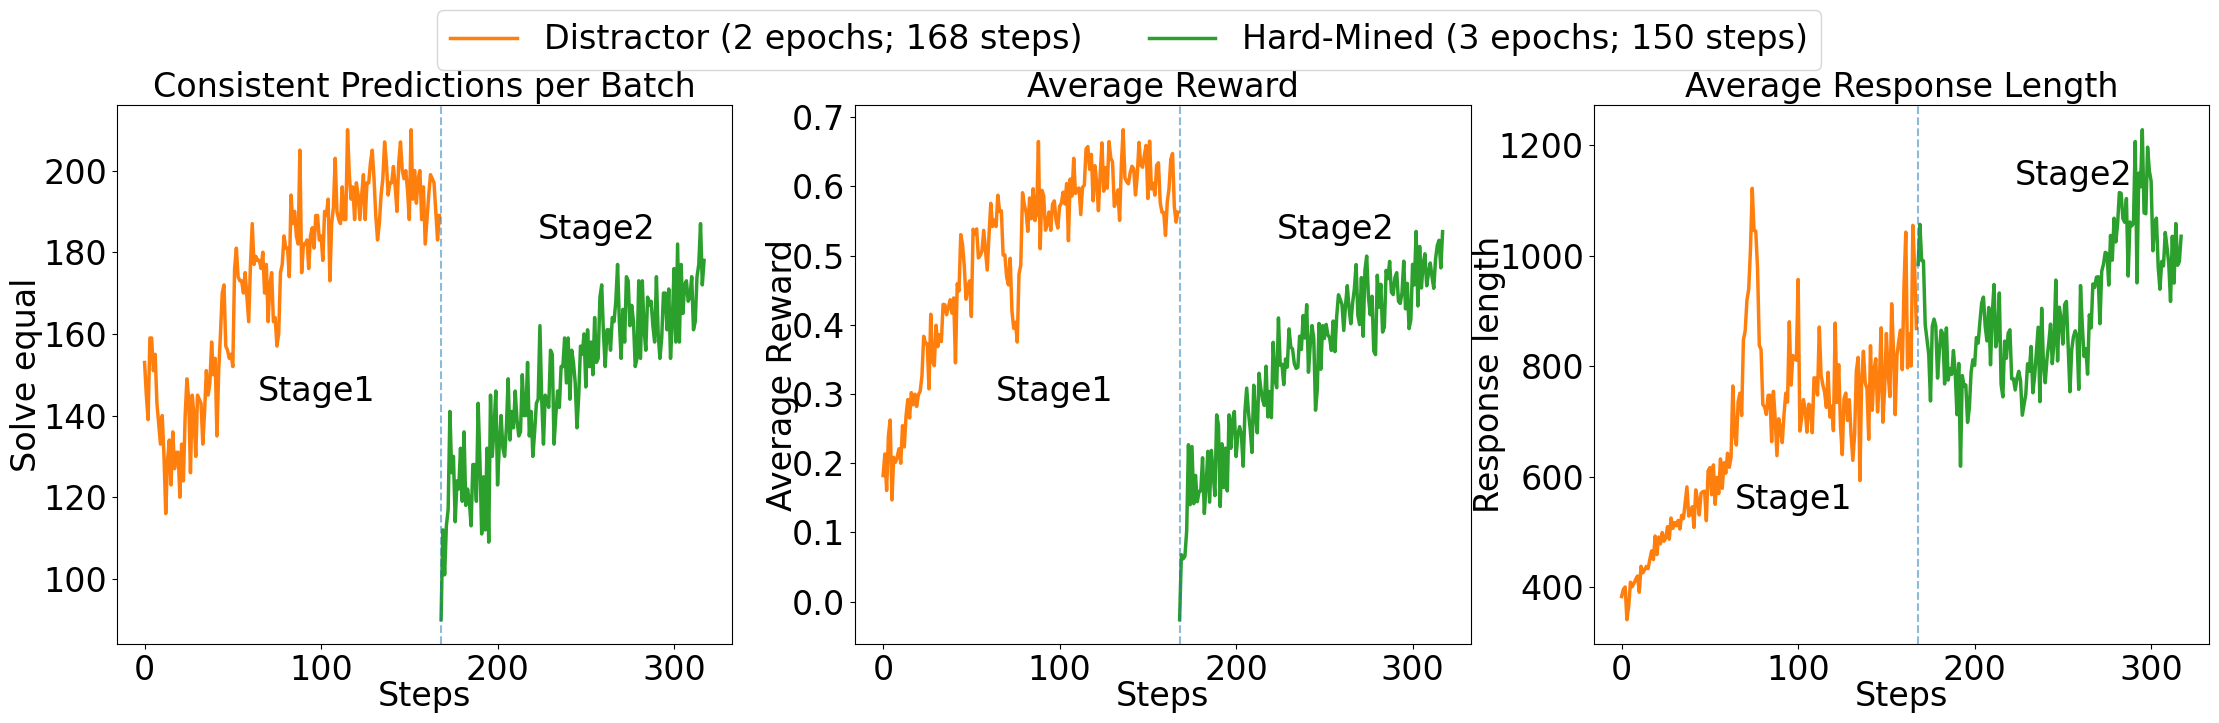

In [24]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Training metrics plot for rStar2-Long-14B (two-stage schedule).
- Left: Consistent Predictions per Batch (Solve equal)
- Middle: Average Reward (fixed-reward proxy)
- Right: Average Response Length
Layout: constrained_layout (tight & even), top legend outside, no overlap.
"""

import numpy as np
import matplotlib.pyplot as plt
import wandb

# -----------------------------
# Config
# -----------------------------
PROJECT_RUN_1 = "nobleai-xjtu/verl_rej_test/runs/verl_rej_test--qwen25_14B_mi300_2node_16k_2k_math_filtered_dis_mathqa_256bsz_20ksamples_grpo_subem_end"  # Distractor phase
PROJECT_RUN_2 = "nobleai-xjtu/verl_rej_test/verl_rej_test--qwen14b_2e_1node_16k_2k_FILTERedAGAIN_dis_256bsz_grpo_SUBEM_end"                               # Hard-mined phase

# Stage lengths (steps)
X1 = 168  # Distractor
X2 = 150  # Hard-mined
BATCHSIZE = 256

# -----------------------------
# Data helpers
# -----------------------------
def fixed_reward_series(run, batchsize=BATCHSIZE):
    """Return per-step fixed-reward estimate: (mean_return * (B - wrong - right) + right) / B"""
    hist = run.history(keys=[
        "critic/returns/mean",
        "critic/num_all_right",
        "critic/num_all_wrong",
    ])
    returns_mean = np.array(hist.get("critic/returns/mean", []), dtype=float)
    num_right    = np.array(hist.get("critic/num_all_right", []), dtype=float)
    num_wrong    = np.array(hist.get("critic/num_all_wrong", []), dtype=float)
    L = min(len(returns_mean), len(num_right), len(num_wrong))
    returns_mean, num_right, num_wrong = returns_mean[:L], num_right[:L], num_wrong[:L]
    return (returns_mean * (batchsize - num_wrong - num_right) + num_right) / batchsize

def get_response_length(run):
    hist = run.history(keys=["response_length/mean"])
    return np.array(hist.get("response_length/mean", []), dtype=float)

def get_solve_equal(run):
    hist = run.history(keys=["batch/solve_equal"])
    return np.array(hist.get("batch/solve_equal", []), dtype=float)

# -----------------------------
# Fetch data from W&B
# -----------------------------
api = wandb.Api()
run_dis = api.run(PROJECT_RUN_1)  # Distractor
run_hm  = api.run(PROJECT_RUN_2)  # Hard-mined

y_dis_rew   = fixed_reward_series(run_dis)[:X1]
y_hm_rew    = fixed_reward_series(run_hm)[:X2]
y_dis_len   = get_response_length(run_dis)[:X1]
y_hm_len    = get_response_length(run_hm)[:X2]
y_dis_solve = get_solve_equal(run_dis)[:X1]
y_hm_solve  = get_solve_equal(run_hm)[:X2]

# -----------------------------
# Plot style (应用与你上一段一致的参数)
# -----------------------------
line_width      = 2.5
label_fontsize  = 24
title_fontsize  = 24
tick_fontsize   = 24
legend_fontsize = 24
split_fontsize  = 24

# 关键：只用 constrained_layout 管理间距；gridspec_kw + pads 让子图更紧凑且等距
fig, axes = plt.subplots(
    1, 3, figsize=(27, 7), sharex=False,
    constrained_layout=True, gridspec_kw={'wspace': 0.2}
)
fig.set_constrained_layout_pads(wspace=0.02, hspace=0.02)

colors     = {"dis": "C1", "hm": "C2"}
legend_dis = "Distractor (2 epochs; 168 steps)"
legend_hm  = "Hard-Mined (3 epochs; 150 steps)"

# X for two stages on a shared axis
x_dis = np.arange(0, X1)
x_hm  = np.arange(X1, X1 + X2)

def add_stage_split(ax, xpos, label, y_frac=0.95):
    """Add vertical split with annotation. y_frac controls vertical placement (0~1)."""
    ax.axvline(x=xpos, linestyle="--", alpha=0.5, linewidth=1.5)
    ymin, ymax = ax.get_ylim()
    ax.text(
        xpos + 2, ymin + y_frac * (ymax - ymin),
        label, fontsize=split_fontsize, va="top"
    )

# -----------------------------
# Panel 1: Solve equal
# -----------------------------
ax = axes[0]
ax.plot(x_dis, y_dis_solve, label=legend_dis, color=colors["dis"], linewidth=line_width)
ax.plot(x_hm,  y_hm_solve,  label=legend_hm,  color=colors["hm"],  linewidth=line_width)
# add_stage_split(ax, X1, "Stage1", y_frac=0.85)  # 与你上一段相同的相对高度
ax.axvline(x=X1, linestyle="--", alpha=0.5, linewidth=1.5)
ymin, ymax = ax.get_ylim()
ax.text(X1//2-20, ymin + 0.5 * (ymax - ymin), "Stage1", fontsize=split_fontsize, va="top")
ax.text(X1 + (X2//2)-20, ymin + 0.8 * (ymax - ymin), "Stage2", fontsize=split_fontsize, va="top")
ax.set_xlabel("Steps", fontsize=label_fontsize, labelpad=-5)
ax.set_ylabel("Solve equal", fontsize=label_fontsize, labelpad=0)
ax.set_title("Consistent Predictions per Batch", fontsize=title_fontsize)
ax.tick_params(axis="both", labelsize=tick_fontsize)

# -----------------------------
# Panel 2: Average Reward
# -----------------------------
ax = axes[1]
ax.plot(x_dis, y_dis_rew, label=legend_dis, color=colors["dis"], linewidth=line_width)
ax.plot(x_hm,  y_hm_rew,  label=legend_hm,  color=colors["hm"],  linewidth=line_width)
# add_stage_split(ax, X1, "Distractor\n→Hard-Mined", y_frac=0.85)
ax.axvline(x=X1, linestyle="--", alpha=0.5, linewidth=1.5)
ymin, ymax = ax.get_ylim()
ax.text(X1//2-20, ymin + 0.5 * (ymax - ymin), "Stage1", fontsize=split_fontsize, va="top")
ax.text(X1 + (X2//2)-20, ymin + 0.8 * (ymax - ymin), "Stage2", fontsize=split_fontsize, va="top")
ax.set_xlabel("Steps", fontsize=label_fontsize, labelpad=-5)
ax.set_ylabel("Average Reward", fontsize=label_fontsize, labelpad=-5)
ax.set_title("Average Reward", fontsize=title_fontsize)
ax.tick_params(axis="both", labelsize=tick_fontsize)

# -----------------------------
# Panel 3: Response Length
# -----------------------------
ax = axes[2]
ax.plot(x_dis, y_dis_len, label=legend_dis, color=colors["dis"], linewidth=line_width)
ax.plot(x_hm,  y_hm_len,  label=legend_hm,  color=colors["hm"],  linewidth=line_width)
# 先在 0.95 放第一个分割（这里只有一个分割
# add_stage_split(ax, X1, "Distractor\n→Hard-Mined", y_frac=0.3)  # 与你上一段一致
ymin, ymax = ax.get_ylim()
ax.axvline(x=X1, linestyle="--", alpha=0.5, linewidth=1.5)
ax.text(X1//2-20, ymin + 0.3 * (ymax - ymin), "Stage1", fontsize=split_fontsize, va="top")
ax.text(X1 + (X2//2)-20, ymin + 0.9 * (ymax - ymin), "Stage2", fontsize=split_fontsize, va="top")
ax.set_xlabel("Steps", fontsize=label_fontsize, labelpad=-5)
ax.set_ylabel("Response length", fontsize=label_fontsize, labelpad=-5)
ax.set_title("Average Response Length", fontsize=title_fontsize)
ax.tick_params(axis="both", labelsize=tick_fontsize)

# ---------- 全局等距对齐（消除y轴装饰导致的视觉不等距） ----------
fig.align_ylabels(axes)

# ---------- 全局图例（置于图外上方，留足空间，不重叠） ----------
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="upper center",
    ncol=2, bbox_to_anchor=(0.5, 1.04),
    fontsize=legend_fontsize,
)

# 注意：不要再使用 tight_layout()，避免与 constrained_layout 冲突
outfile = "qwen-14b_keychain_train_hardmined_font_big.pdf"
plt.tight_layout(rect=[0, 0, 1, 0.92])
fig.savefig(outfile, bbox_inches="tight", pad_inches=0.02)
print(f"Saved to {outfile}")